In [1]:
!pip install tensorflow

In [2]:
# 安装 Kaggle 库
!pip install -q kaggle

# 创建 .kaggle 文件夹
!mkdir -p ~/.kaggle

# 假设你的 kaggle.json 文件在当前目录中，将其复制到 .kaggle 文件夹
!cp kaggle.json ~/.kaggle/

# 设置权限
!chmod 600 ~/.kaggle/kaggle.json

# 下载数据集
!kaggle datasets download -d yuzhouzhu/attosecond-streaking-phase-retrieval-data-8w

# 解压数据集
!unzip attosecond-streaking-phase-retrieval-data-8w.zip -d data/

import pandas as pd

# 加载训练数据
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/y_train.csv')

# 查看数据
print("finish")


Dataset URL: https://www.kaggle.com/datasets/yuzhouzhu/attosecond-streaking-phase-retrieval-data-8w
License(s): MIT
100% 6.03G/6.04G [00:46<00:00, 117MB/s]
100% 6.04G/6.04G [00:46<00:00, 138MB/s]
Archive:  attosecond-streaking-phase-retrieval-data-8w.zip
  inflating: data/X_train.csv        
  inflating: data/y_train.csv        
finish


In [18]:
import os

After reshape: X_train_np.shape = (79999, 301, 58, 1)
y_train_np.shape = (79999, 290)
模型文件 /content/swin_model.h5 找到。


模型加载成功。
随机选到的连续段起始索引: [11513, 13386, 27243, 39649]
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


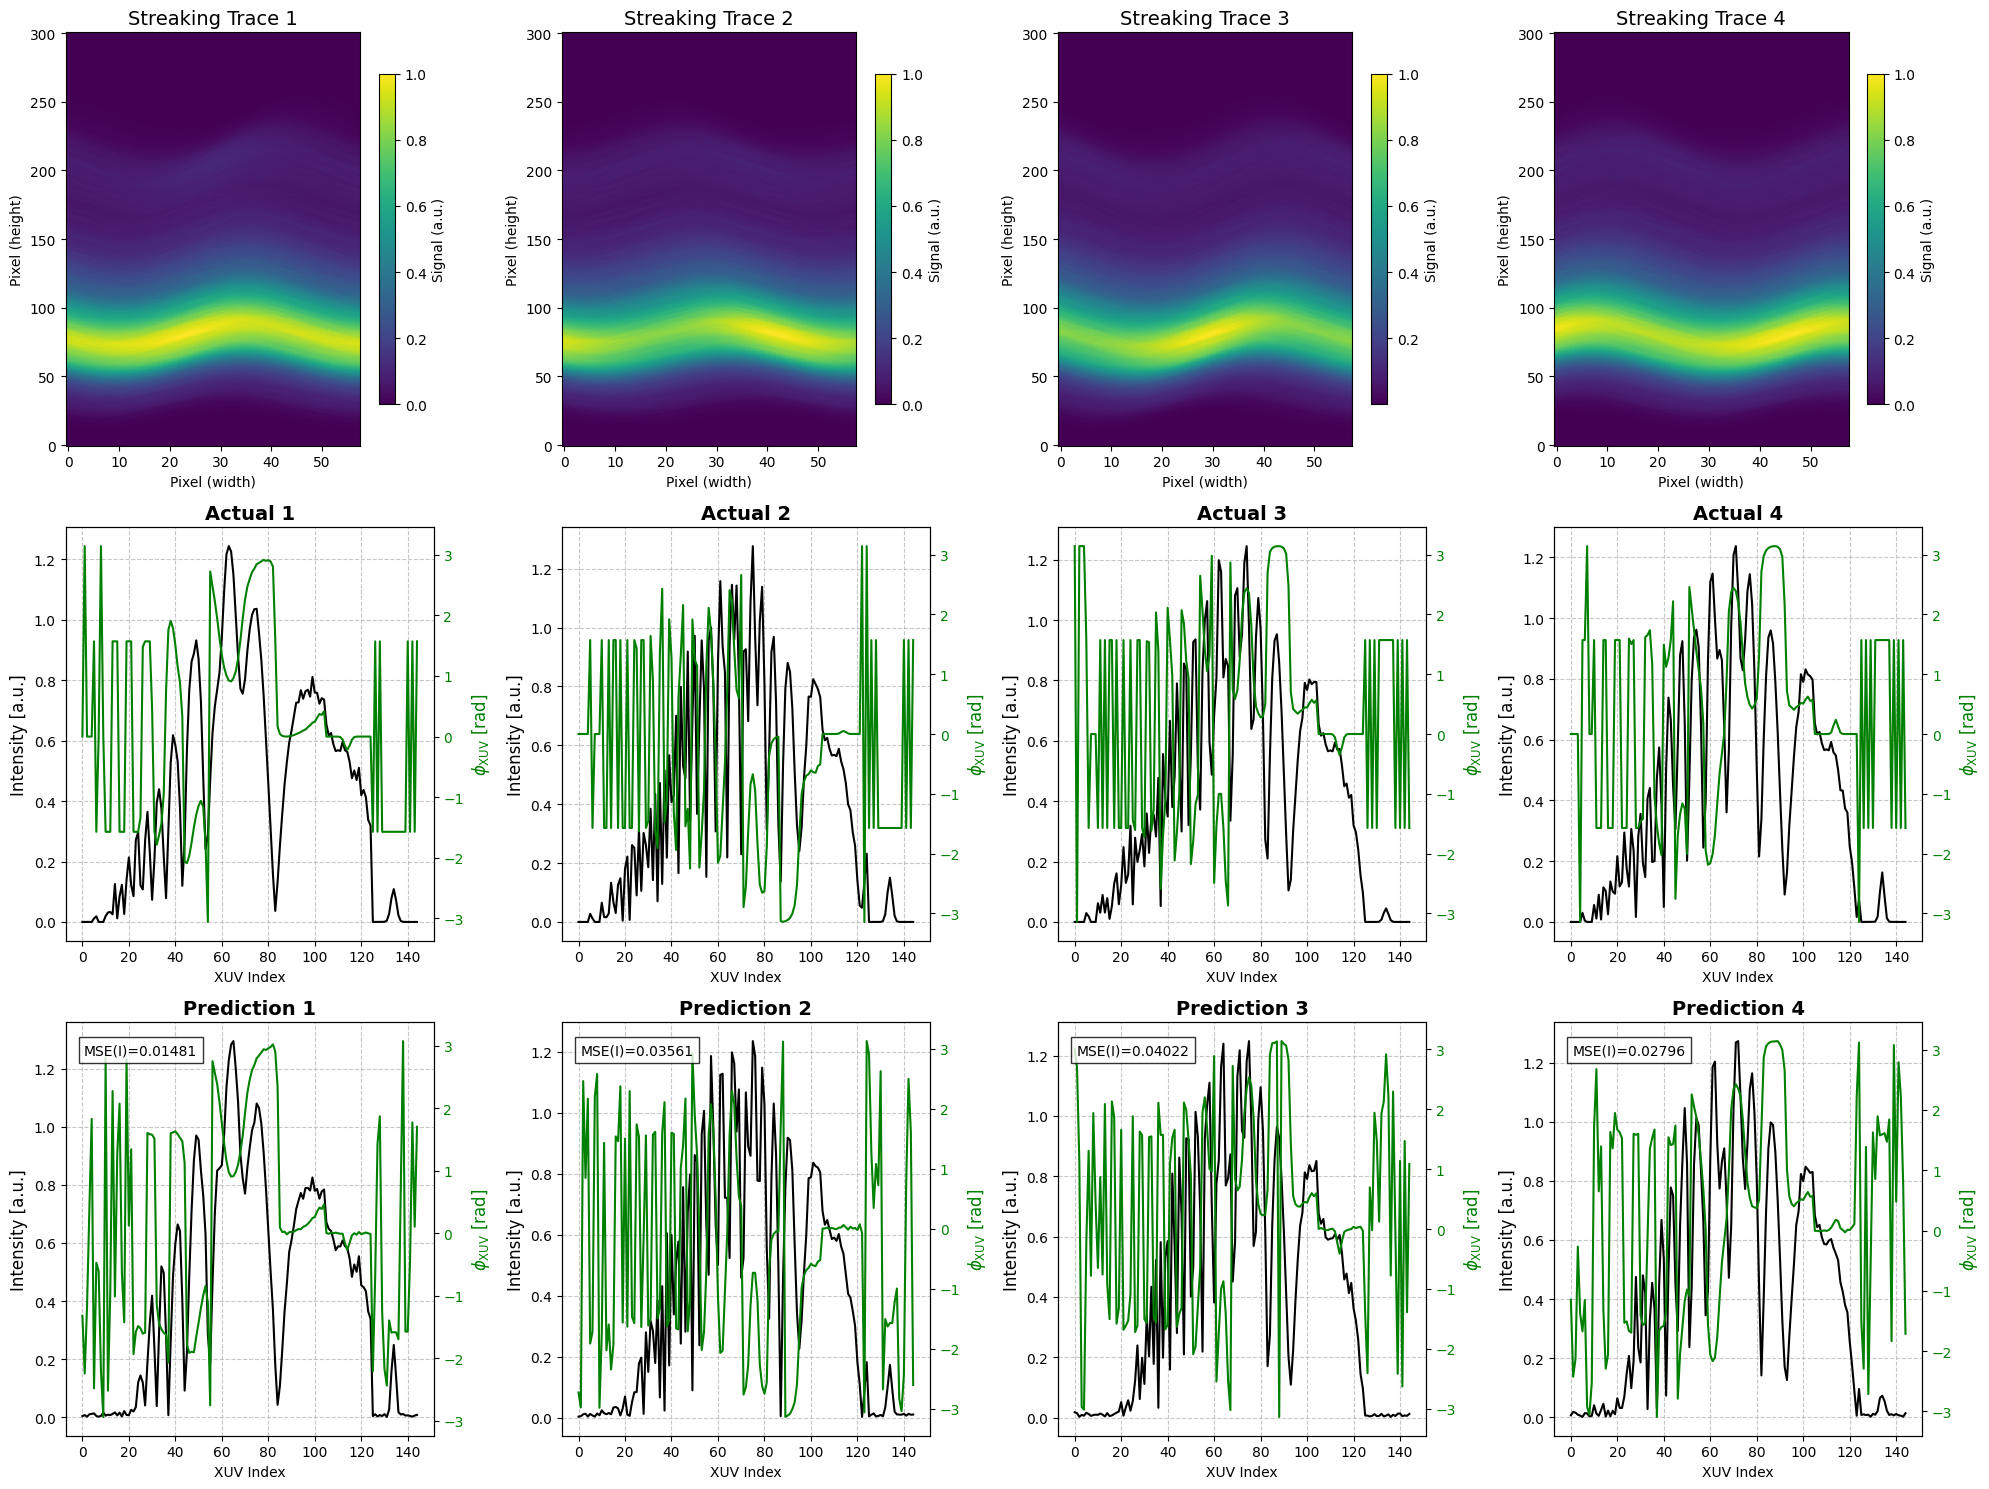

In [23]:
# 假设每个条纹图大小为 (301, 58)
img_height, img_width = 301, 58

# 转换为 NumPy 数组并 reshape
X_train_np = X_train.values.astype(np.float32).reshape((-1, img_height, img_width, 1))  # 添加通道维度
y_train_np = y_train.values.astype(np.float32)

num_samples = X_train_np.shape[0]
print("After reshape: X_train_np.shape =", X_train_np.shape)
print("y_train_np.shape =", y_train_np.shape)

# 5. 定义Swin Transformer的自定义层
import tensorflow as tf
from tensorflow.keras import layers, models, losses

class SwinBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, window_size, shift_size=0, ff_dim=128, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size

        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, mask=None, training=False):
        # 注意力机制
        attn_output = self.att(x, x, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        # 前馈网络
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# 6. 定义自定义的Cast层
class CastLayer(layers.Layer):
    def __init__(self, cast_dtype='float32', **kwargs):
        super().__init__(**kwargs)
        self.cast_dtype = cast_dtype

    def call(self, inputs):
        return tf.cast(inputs, self.cast_dtype)

    def get_config(self):
        config = super().get_config()
        config.update({'cast_dtype': self.cast_dtype})
        return config

# 7. 设置混合精度策略
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# 8. 加载预训练的Swin模型
from tensorflow.keras.models import load_model

# 定义custom_objects以匹配Swin模型中的自定义层
custom_objects = {
    "SwinBlock": SwinBlock,
    "Cast": CastLayer,  # 修改后的 Cast 层
    "mse": losses.MeanSquaredError
}

model_path = '/content/swin_model.h5'  # 确保路径正确

if not os.path.exists(model_path):
    # 如果模型保存在Google Drive中，请挂载Drive并设置正确的路径
    from google.colab import drive
    drive.mount('/content/drive')
    model_path = '/content/drive/My Drive/swin_model.h5'
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"模型文件 {model_path} 不存在。请确保模型已上传。")
    else:
        print(f"模型文件 {model_path} 找到。")
else:
    print(f"模型文件 {model_path} 找到。")

# 加载模型
try:
    model = load_model(model_path, custom_objects=custom_objects)
    print("模型加载成功。")
except ValueError as e:
    print(f"加载模型时出错: {e}")
    print("尝试在custom_objects中添加更多自定义层或检查模型保存过程。")

# 9. 随机抽取4个连续片段，每个500条
import random

segment_len = 500
num_sets = 4
max_start = num_samples - segment_len

start_indices = []
while len(start_indices) < num_sets:
    start_idx = random.randint(0, max_start)
    # 避免重叠
    conflict = any(abs(s - start_idx) < segment_len for s in start_indices)
    if not conflict:
        start_indices.append(start_idx)

start_indices.sort()
print("随机选到的连续段起始索引:", start_indices)

test_sets = []
for st in start_indices:
    X_test_part = X_train_np[st : st + segment_len]
    y_test_part = y_train_np[st : st + segment_len]
    test_sets.append((X_test_part, y_test_part))

# 10. 可视化结果
import matplotlib.pyplot as plt

split_xuv = 145  # 根据y的实际长度调整，这里假设y有290个元素

plt.figure(figsize=(5 * num_sets, 15))  # 调整图形大小以适应三行

for i, (X_test_part, Y_test_part) in enumerate(test_sets):
    x_sample = X_test_part[0]
    y_true = Y_test_part[0]

    # 模型预测
    y_pred = model.predict(np.expand_dims(x_sample, axis=0))[0]

    # -- 第一行：Streaking Trace
    plt.subplot(3, num_sets, i + 1)
    plt.title(f"Streaking Trace {i+1}", fontsize=14)
    plt.imshow(x_sample.squeeze(), origin='lower', aspect='auto', cmap='viridis')
    plt.colorbar(label='Signal (a.u.)', shrink=0.8)
    plt.xlabel("Pixel (width)")
    plt.ylabel("Pixel (height)")

    # 拆分 y_true
    if len(y_true) >= 2 * split_xuv:
        y_true_real = y_true[:split_xuv]
        y_true_imag = y_true[split_xuv:2*split_xuv]
    else:
        # 根据y的实际长度进行调整
        mid = len(y_true) // 2
        y_true_real = y_true[:mid]
        y_true_imag = y_true[mid:]

    true_intensity = np.sqrt(y_true_real**2 + y_true_imag**2)
    true_phase = np.arctan2(y_true_imag, y_true_real)

    # 第二行：Actual
    plt.subplot(3, num_sets, num_sets + i + 1)
    plt.title(f"Actual {i+1}", fontsize=14, fontweight='bold')
    plt.plot(true_intensity, color='black', linewidth=1.5, label='Intensity')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylabel("Intensity [a.u.]", fontsize=12, color='black')
    plt.xlabel("XUV Index")
    plt.tick_params(axis='y', labelcolor='black')

    ax2 = plt.gca().twinx()
    ax2.plot(true_phase, color='green', linewidth=1.5, label='Phase')
    ax2.set_ylabel(r'$\phi_{\mathrm{XUV}}$ [rad]', fontsize=12, color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # 拆分 y_pred
    if len(y_pred) >= 2 * split_xuv:
        y_pred_real = y_pred[:split_xuv]
        y_pred_imag = y_pred[split_xuv:2*split_xuv]
    else:
        mid = len(y_pred) // 2
        y_pred_real = y_pred[:mid]
        y_pred_imag = y_pred[mid:]

    pred_intensity = np.sqrt(y_pred_real**2 + y_pred_imag**2)
    pred_phase = np.arctan2(y_pred_imag, y_pred_real)

    # 第三行：Prediction
    plt.subplot(3, num_sets, 2 * num_sets + i + 1)
    plt.title(f"Prediction {i+1}", fontsize=14, fontweight='bold')
    plt.plot(pred_intensity, color='black', linewidth=1.5, label='Intensity')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylabel("Intensity [a.u.]", fontsize=12, color='black')
    plt.xlabel("XUV Index")
    plt.tick_params(axis='y', labelcolor='black')

    ax3 = plt.gca().twinx()
    ax3.plot(pred_phase, color='green', linewidth=1.5, label='Phase')
    ax3.set_ylabel(r'$\phi_{\mathrm{XUV}}$ [rad]', fontsize=12, color='green')
    ax3.tick_params(axis='y', labelcolor='green')

    # 计算并显示MSE
    mse_intensity = np.mean((pred_intensity - true_intensity)**2)
    plt.text(
        0.05, 0.95,
        f"MSE(I)={mse_intensity:.5f}",
        fontsize=10,
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(facecolor='white', alpha=0.8)
    )

plt.tight_layout()
plt.show()